# Decision Trees
This project aims to use Decision Trees to analysis if there is a correspondence between eye color and other traits.

The data used is JSE Data Archive data. It contains biological and self-reported activity traits of a sample of colloge students at a university in 2013.

FEATURES: 

<ul>
<li>Color (Blue, Brown, Green, Hazel, Other)
<li>Age (in years)
<li>YearinSchool (First, Second, Third, Fourth, Other)
<li>Height (in inches)
<li>Miles (distance from home town of student to Ames, IA) 
<li>Brothers (number of brothers)
<li>Sisters (number of sisters)
<li>CompTime (number of hours spent on computer per week)
<li>Exercise (whether the student exercises Yes or No)
<li>ExerTime (number of hours spent exercising per week)
<li>MusicCDs (number of music CDs student owns)
<li>PlayGames (number of hours spent playing games per week)
<li>WatchTV (number of hours spent watching TV per week
</ul>

In [ ]:
from collections import Counter, defaultdict
from itertools import combinations 
import pandas as pd
import numpy as np
import operator
#train test split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
!wget http://people.ischool.berkeley.edu/~zp/course_datasets/eye_color.zip
!unzip eye_color.zip
!ls
 

--2020-11-13 03:21:59--  http://people.ischool.berkeley.edu/~zp/course_datasets/eye_color.zip
Resolving people.ischool.berkeley.edu (people.ischool.berkeley.edu)... 128.32.78.16
Connecting to people.ischool.berkeley.edu (people.ischool.berkeley.edu)|128.32.78.16|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://people.ischool.berkeley.edu/~zp/course_datasets/eye_color.zip [following]
--2020-11-13 03:22:00--  https://people.ischool.berkeley.edu/~zp/course_datasets/eye_color.zip
Connecting to people.ischool.berkeley.edu (people.ischool.berkeley.edu)|128.32.78.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23344 (23K) [application/zip]
Saving to: ‘eye_color.zip’

eye_color.zip       100%[===================>]  22.80K  --.-KB/s    in 0.1s    

2020-11-13 03:22:00 (167 KB/s) - ‘eye_color.zip’ saved [23344/23344]

Archive:  eye_color.zip
  inflating: Eye_Color.csv           
  inflating: Eye_Color_Dataset_Descripti

In [ ]:
df = pd.read_csv('Eye_Color.csv')

# removing NA's and reseting the index
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df = df.reset_index(drop=True)

# Calculating Gini Index 

The Gini Coefficient or Gini Index is a measurement of inequality among values of a variable. The higher the value, the more dispered the data. The closer the index is to zero, the higher the equality and lower the inequality and vise-versa.

The initial Gini Index of this dataset is created using males and females as target classes. 


In [ ]:
# YOUR CODE HERE
df['gender'].value_counts()

female    1078
male       910
Name: gender, dtype: int64

In [ ]:
# YOUR CODE HERE
n = df.gender.value_counts().female
m = df.gender.value_counts().male
total_gender = n+m

gini_index_gender = 1 - (n/total_gender)**2 - (m/total_gender)**2
gini_index_gender

0.4964292799047808

In [ ]:
total_gender

1988

With a gini index of 0.49, there is about a 50/50 split between male and females. 

# Best split for Numerical Features

Here, I find split points for the decision trees within the numerical features. 

First, I look at the hieght feature.

In [ ]:
df3 = df.sort_values('height', ascending=True).reset_index(drop=True)
height = df3[['height']]
height.head()

,height
0,44.0
1,52.0
2,54.0
3,56.0
4,56.0


In [ ]:
d = Counter(height['height'])
h_counts = pd.DataFrame.from_dict(d, orient='index').reset_index()
h_counts = h_counts.rename(columns={'index':'height', 0:'count'})
h_counts = h_counts[['height','count']].astype(int) #couldn't figure out how to slice through lists, so convert to df first then slice.
h_counts.head()

,height,count
0,44,1
1,52,1
2,54,1
3,56,3
4,57,2


In [ ]:
data = h_counts['count'].values.tolist()
data

[1,
 1,
 1,
 3,
 2,
 3,
 5,
 21,
 31,
 83,
 99,
 146,
 158,
 139,
 192,
 162,
 147,
 182,
 119,
 185,
 88,
 73,
 61,
 36,
 25,
 15,
 5,
 2,
 2,
 1]

In [ ]:
def running_sum(a):
  tot = 0
  for item in a:
    tot += item
    yield tot
    
counts_previous = list(running_sum(data))
h_counts['running count'] = counts_previous
h_counts.head() 

,height,count,running count
0,44,1,1
1,52,1,2
2,54,1,3
3,56,3,6
4,57,2,8


I now need to find number of females and males associated with these heights. So I create a female and male count:

In [ ]:
df3_no2 = df[['gender', 'height']].copy()
df3_n2 = df3_no2.replace({'female':['f'],'male':['m']})
df3_fm = df3_n2.groupby(['height']).sum()
df3_fm['f_counts'] = df3_fm['gender'].apply(lambda E:E.count('f'))
df3_fm['m_counts'] = df3_fm['gender'].apply(lambda E:E.count('m'))
df3_fm_final = df3_fm[['f_counts','m_counts']].copy().reset_index(drop=True)

dataf = df3_fm_final['f_counts'].values.tolist()
datam = df3_fm_final['m_counts'].values.tolist()

counts_previousf = list(running_sum(dataf))
counts_previousm = list(running_sum(datam))

df3_fm_final['running counts of female'] = counts_previousf
df3_fm_final['running counts of male'] = counts_previousm

df3_fm_final.head()

,f_counts,m_counts,running counts of female,running counts of male
0,1,0,1,0
1,1,0,2,0
2,1,0,3,0
3,3,0,6,0
4,2,0,8,0


In [ ]:
#combine h_counts with df3_fm_final\
df3_cleaned = h_counts.join(df3_fm_final)
df3_cleaned.head()

,height,count,running count,f_counts,m_counts,running counts of female,running counts of male
0,44,1,1,1,0,1,0
1,52,1,2,1,0,2,0
2,54,1,3,1,0,3,0
3,56,3,6,3,0,6,0
4,57,2,8,2,0,8,0


In [ ]:
final_df3 = df3_cleaned[['height', 'running count', 'running counts of female', 'running counts of male']]
final_df3.head()

,height,running count,running counts of female,running counts of male
0,44,1,1,0
1,52,2,2,0
2,54,3,3,0
3,56,6,6,0
4,57,8,8,0


In [ ]:
print(final_df3['running count'].values[29])

1988


In [ ]:
sum_count = h_counts['count'].sum()
fsum_count = df3_cleaned['f_counts'].sum()
msum_count = df3_cleaned['m_counts'].sum()


#heights below = final_df3.running count.values[row]
#hieghts above = sum_count - final_df3.running count.values[row]
#males in term 1 = final_df3.running counts of male.values[row]
#females in term 1 = final_df3.running counts of female.values[row]
#males in term 2 = msum_count - final_df3.running counts of male.values[row]
#females in term 2 = fsum_count - final_df3.running counts of female.values[row]


split_point = 54
min_value = 54

for row in final_df3.index.values:
  
  
  gini_index = (
        (final_df3['running count'].values[row]/sum_count)*(
          1 - 
          (final_df3['running counts of female'].values[row]/final_df3['running count'].values[row])**2 
          - (final_df3['running counts of male'].values[row]/final_df3['running count'].values[row])**2 )
  
      +
       ( ((sum_count - final_df3['running count'].values[row])/sum_count)*(
          1 - 
          ((fsum_count - final_df3['running counts of female'].values[row])/(sum_count - final_df3['running count'].values[row]))**2 
  - ((msum_count - final_df3['running counts of male'].values[row])/(sum_count - final_df3['running count'].values[row]))**2 )
  
 )
   
  )
  
  if gini_index < min_value:   
    min_value = gini_index
    split_point = (final_df3.height.values[row] + final_df3.height.values[row +1])/2 
    
print('The split point was found to be'+ ' ' + str(split_point))

The split point was found to be 68.5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
print('The Gini Index of this split is ' + str(min_value))
print('This partitioning reduces the Gini Index of the overall dataset by ' + str(gini_index_gender - min_value))

The Gini Index of this split is 0.26552881207029194
This partitioning reduces the Gini Index of the overall dataset by 0.23090046783448887



Best Split of a Categorical Variable

First question was to find the possible splits in the eyecolor feature.


In [ ]:
import itertools

#a = Blue, b = Brown, c = Green, d = Hazel, e = Other

def power_set(s="abcde"):   
  # Your code
  return list(itertools.chain.from_iterable(
      itertools.combinations(s, r) for r in range(1, len(s)+1)))

int(len(power_set(['Blue','Brown','Green', 'Hazel', 'Other']))/2)

15

In [ ]:
x = power_set(['blue','brown','green', 'hazel', 'other'])[15:]
np.asarray(x)

array([('blue', 'brown', 'green'), ('blue', 'brown', 'hazel'),
       ('blue', 'brown', 'other'), ('blue', 'green', 'hazel'),
       ('blue', 'green', 'other'), ('blue', 'hazel', 'other'),
       ('brown', 'green', 'hazel'), ('brown', 'green', 'other'),
       ('brown', 'hazel', 'other'), ('green', 'hazel', 'other'),
       ('blue', 'brown', 'green', 'hazel'),
       ('blue', 'brown', 'green', 'other'),
       ('blue', 'brown', 'hazel', 'other'),
       ('blue', 'green', 'hazel', 'other'),
       ('brown', 'green', 'hazel', 'other'),
       ('blue', 'brown', 'green', 'hazel', 'other')], dtype=object)

In [ ]:
print('There are ' + str(int(len(x))-1) + ' possible splits')

There are 15 possible splits


Now I find the split of eyecolor that best splits the female and male rows using the Gini Index:

In [ ]:
total = df.shape[0] #total number of rows

df9 = df.copy()
splits = np.asarray(power_set(['blue','brown','green', 'hazel', 'other']))

split_color = ''
min_value = 1000
  


for split in range(len(splits) - 1):
  split1_total = df9[(df9.eyecolor.isin(splits[split]))].shape[0]
  split2_total = df9[(~df9.eyecolor.isin(splits[split]))].shape[0]
  
  split1_mtotal = df9[(df9.gender == 'male') & (df9.eyecolor.isin(splits[split]))].shape[0]
  split2_mtotal = df9[(df9.gender == 'male') & (~df9.eyecolor.isin(splits[split]))].shape[0]
  
  split1_ftotal = df9[(df9.gender == 'female') & (df9.eyecolor.isin(splits[split]))].shape[0]
  split2_ftotal = df9[(df9.gender == 'female') & (~df9.eyecolor.isin(splits[split]))].shape[0]
  
  
  gini_index = (
      
  (split1_total/total)*(1 - (split1_mtotal/split1_total)**2 - (split1_ftotal/split1_total)**2)+
  (split2_total/total)*(1 - (split2_mtotal/split2_total)**2 - (split2_ftotal/split2_total)**2)  
    
  )
  
  if gini_index < min_value:   
    min_value = gini_index
    split_color = splits[split] 
    m1 = split1_mtotal
    m2 = split2_mtotal
    f1 = split1_ftotal
    f2 = split2_ftotal


print('The best split color that best split the female and male rows is ' + str(split_color))
print('The Gini Index of this best split is ' + str(min_value))
print('This partitioning reduces the Gini Index of the overall data set by ' + str(gini_index_gender - min_value))

The best split color that best split the female and male rows is ('green',)
The Gini Index of this best split is 0.4930915729509777
This partitioning reduces the Gini Index of the overall data set by 0.003337706953803088


# Decision Tree Training

Here, a decision tree classifier with depth three (including root node and leaf nodes) is created and then trained using the features of the original dataframe. 

The class labels and features are turned into numeric arrays using DictVectorizer. Class label is removed, this prevents training accuracy from erronously being 100 percent. 

In [ ]:
df13 = df.loc[:,'age':'watchtv'].copy() #gender removed
df13.head()

,age,year,eyecolor,height,miles,brothers,sisters,computertime,exercise,exercisehours,musiccds,playgames,watchtv
0,18,first,hazel,68.0,195.0,0,1,20.0,Yes,3.0,75.0,6.0,18.0
1,20,third,brown,70.0,120.0,3,0,24.0,No,0.0,50.0,0.0,3.0
2,18,first,green,67.0,200.0,0,1,35.0,Yes,3.0,53.0,8.0,1.0
3,23,fourth,hazel,74.0,140.0,1,1,5.0,Yes,25.0,50.0,0.0,7.0
4,19,second,blue,62.0,60.0,0,1,5.0,Yes,4.0,30.0,2.0,5.0


In [ ]:
df_classlabels = df['gender'].copy()

In [ ]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer #to turn categorial variables into numeric arrays
from sklearn import preprocessing #to transform the feature labels
#u can turn a pandas dataframe of features into a 
#dictionary of the form needed by DictVectorizer by using df.to_dict('records'). 
vec = DictVectorizer()
df13_D = df13.T.to_dict().values()
#DictVectorizer
df13_X = vec.fit_transform(df13_D).toarray()

#Because the labels are also categorical, those need to be transformed as well. 
#There's a special LabelEncoder() object specifically for this task.
le = preprocessing.LabelEncoder()
le.fit(['male', 'female'])
df_classlables_transformarray = le.transform(df_classlabels)

df_classlables_transformarray

array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
df_classlables_transformarray[0].item

<function int64.item>

In [ ]:
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(df13_X, df_classlables_transformarray)
gender_predict = clf.predict(df13_X)

print(accuracy_score(df_classlables_transformarray, gender_predict))

0.8646881287726358


Now, here is a vizualization of the decision tree using 

*   List item
*   List item

graphviz:

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


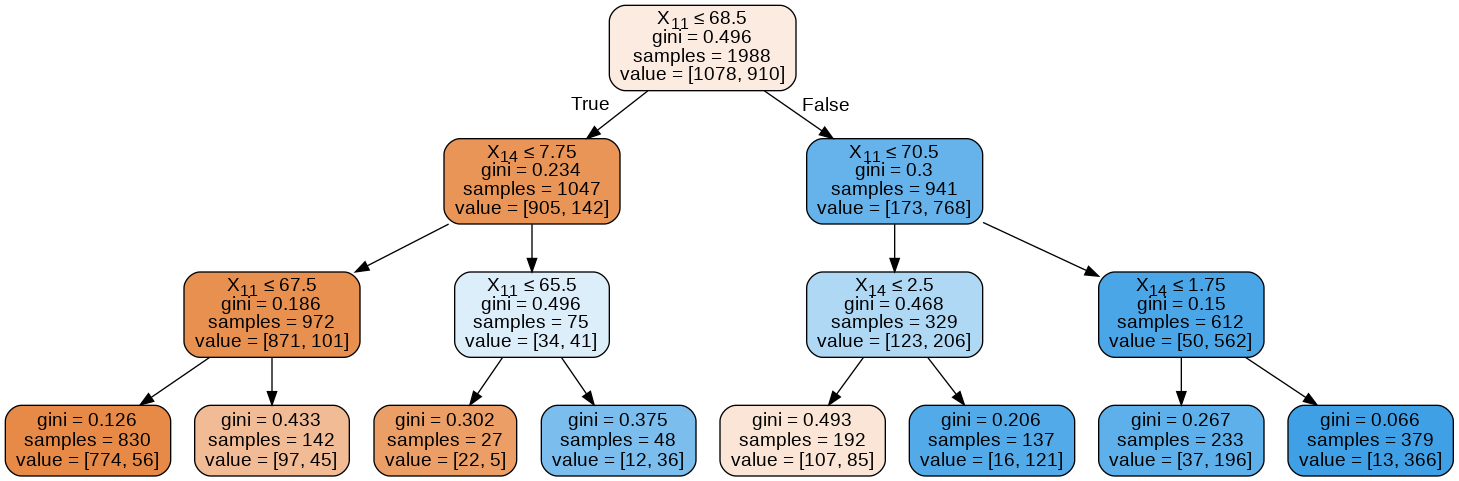

In [ ]:
from IPython.display import Image  
import pydotplus 
import pydot
from sklearn.externals.six import StringIO

#
# clf = your classifier

dotfile = StringIO() 
tree.export_graphviz(clf, out_file=dotfile,
#                     feature_names=df.columns,  
#                          class_names=['Female', 'Male'],  
                         filled=True, rounded=True,  
                         special_characters=True)
                    
graph = pydotplus.graph_from_dot_data(dotfile.getvalue())
Image(graph.create_png())

From Top to bottom left to right. 15 Nodes

Input df 910/1078 = 0.496, this node represents the original input dataframe. Females are True, Males are False.
2/3. With the feature vectors, the descision tree bined what it thinks are males and females. But there is already mistakes it made as node 2 has a small number of males and node 3 vise versa.

4/5/6/7: Here it makes another T/F split from Node 2. Again, it's still tyring to classify on a different T/F feature (which it generated itself) then splits into the final row. I think node 5 and 6 are splitting on gender again. While 4 and 7 are splitting on a different generated feature.

8/9: These nodes have female majority and male minorities as final values.

10/11/12/13: These nodes may have split onto male and female again, as all these nodes have either majority male or female from thier parent node in the final false and true nodes positions respectively.

14/15: these are similar to 8/9 but instead have male majority and female minority as final values.